**Author: Andy Tzanidakis**

In [43]:
from astropy.io import ascii
import os 
from gatspy import datasets, periodic
import gatspy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20

## Motivation

This short tutorial aims to show users how to use some of the basic features of `Gatspy` using the `periodic.LombScargleMultiband`. Almost all methods reviewed here can also be used for `periodic.LombScargleMultibandFast`, `periodic.LombScargle`, and `periodic.LombScargleFast`. For more details please read the GatsPy [docs](https://www.astroml.org/gatspy/periodic/lomb_scargle.html).



For the scope of this notebook, we will be using an RR Lyrae variable from ELASTICC challenge that uses LSST like cadence. The table contains the modified Julian date, flux, flux uncertainty, and photometric filter. We also have stored in each `.ascii` file the metadata that includes the `true_period` of the injected source.

In [22]:
# Load ELASTICC photometry
phot = ascii.read("../data/rrl_sample.ascii") # or you can choose eb_sample.ascii

In [160]:
phot, phot.meta # file contains metadata for true period

(<Table length=208>
    mjd        flux     flux_err band
  float64    float32    float32  str1
 ---------- ---------- --------- ----
 60278.2911  3681.0315  36.57585    z
 60283.2863 -1764.3602 13.710005    g
 60283.3028 -2300.0173 17.559978    r
  60285.312  2187.8438 28.773987    i
 60287.1184  100.92697 23.158018    u
 60290.2895 -235.33426 22.382057    u
 60290.3059 -2714.4348 20.622112    g
 60291.0925  546.45776  27.38656    u
 60291.1096  2672.9253  23.64777    g
 60295.1306   4244.068 28.945269    g
        ...        ...       ...  ...
 61364.2879 -1745.2043 30.833288    z
 61365.3138 -1796.6178 18.645939    g
 61365.3331 -1679.2498 21.881714    r
 61366.3019   862.8603 31.144424    z
 61366.3169  605.03534 48.903126    Y
 61368.3075 -3052.1965 34.953777    z
 61368.3212 -3147.9678 55.378635    Y
 61378.1801 -3376.2844 24.747478    r
 61378.1969 -2064.6245 25.557697    i
  61379.286 -234.22444 22.143238    u,
 OrderedDict([('true_period', 0.5802)]))

### Method 1
Custom two-fold periodogram with zoom-in feature on the 5 highest peaks in the power spectrum.

In [89]:
# Initialize model & model complexity
model = periodic.LombScargleMultiband(fit_period=True, optimizer_kwds={"quiet": False},
                                      Nterms_base=3,
                                      Nterms_band=1,
                                      center_data=True)
model.optimizer.period_range = (0.1, 1)                                   
                                      
model = model.fit(phot['mjd'], phot['flux'], phot['flux_err'], filts=phot['band'])  

print (f"LombScargle Best Period {model.best_period.round(4)} days")

bp = model.best_period # best period in days

Finding optimal frequency:
 - Estimated peak width = 0.00571
 - Using 5 steps per peak; omega_step = 0.00114
 - User-specified period range:  0.1 to 1
 - Computing periods at 49546 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
LombScargle Best Period 0.5802 days


In [31]:
%%time 
model.find_best_periods(n_periods=5) # we can also look at the top 5 peaks in the periodogram

Finding optimal frequency:
 - Estimated peak width = 0.00571
 - Using 5 steps per peak; omega_step = 0.00114
 - User-specified period range:  0.1 to 1
 - Computing periods at 49546 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 1990 steps
CPU times: user 24.4 s, sys: 1min 1s, total: 1min 25s
Wall time: 12.6 s


array([0.58020851, 0.36680256, 0.3671786 , 0.58116037, 0.26816717])

In [29]:
print (phot.meta['true_period'])

0.5802


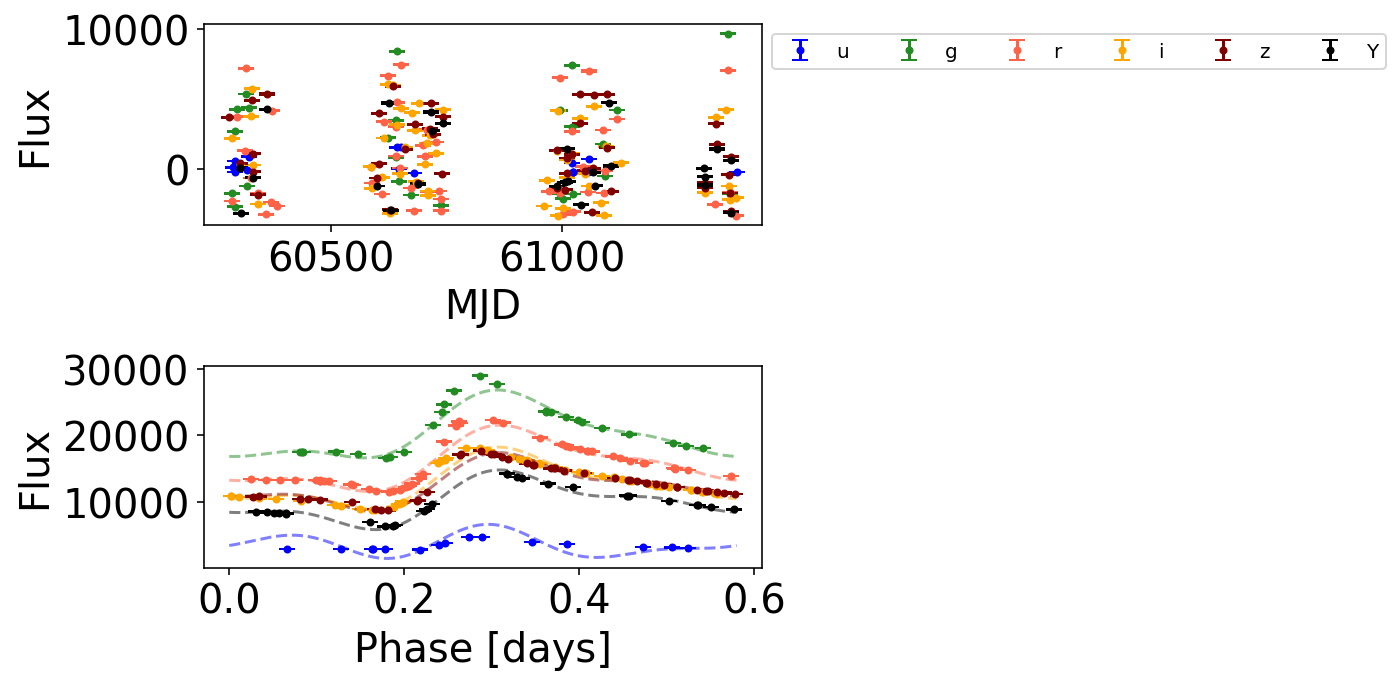

In [112]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,5))
plt.subplots_adjust(hspace=0.7)

for f, clr in zip(list('ugrizY'), ['blue', 'forestgreen', 'tomato', 'orange', 'maroon', 'k']):
    sel_flt = phot['band']==f
    ax[0].errorbar(phot['mjd'][sel_flt], phot['flux'][sel_flt], phot['flux_err'][sel_flt], 
                fmt='.', label=f'{f}', capsize=4, color=clr)
    ax[0].legend(ncol=6, fontsize=10, bbox_to_anchor=(1,1))

    
    
    ax[1].errorbar(phot['mjd'][sel_flt]%model.best_period,
                   phot['flux'][sel_flt]+2*phot['flux'][sel_flt].max(),
                   phot['flux_err'][sel_flt], 
            fmt='.', label=f'{f}', capsize=4, color=clr)
    
    ax[1].plot(np.linspace(0, bp, 1_000), 
               model.predict(np.linspace(0, bp, 1_000),
                             filts=f'{f}')+2*phot['flux'][sel_flt].max(),
              alpha=0.5,color=clr, ls='--')
    
for i in range(2):
    ax[i].set_ylabel("Flux")
    if i==0:
        ax[i].set_xlabel("MJD")
    else:
        ax[i].set_xlabel("Phase [days]")

Nice, we can see that the two-fold periodogram approach implemented by GatsPy was able to correctly recover our injected RRL period. While the above method is a robust approach to recovering the highest peak in the Lomb-Scargle periodogram it does not support any use of the underlying power spectrum.

### Method 2
The power of Gatspy comes to play more specifically when the user: \
    i. Does not want to use the two-fold Lomb-Scargle approach\
    ii. Wants a quicker diagnostic tool for generating upper and lower bounds of the search period
    
Here we show how to use a heuristic approach for generating a periodogram based ont he oversampling factor and nyquist_factor. This powerful implementation skips the two-fold periodogram approach and overall reduces computation time.

In [161]:
%%time
model = periodic.LombScargleMultiband(fit_period=False,
                                      optimizer_kwds={"quiet": True},
                                  Nterms_base=1,
                                  Nterms_band=1,
                                  center_data=True).fit(phot['mjd'], phot['flux'], phot['flux_err'], filts=phot['band']) 

p, dS = model.periodogram_auto(oversampling=5, nyquist_factor=100)

CPU times: user 23.6 s, sys: 54 s, total: 1min 17s
Wall time: 13 s


Period with highest power: 0.5802 days


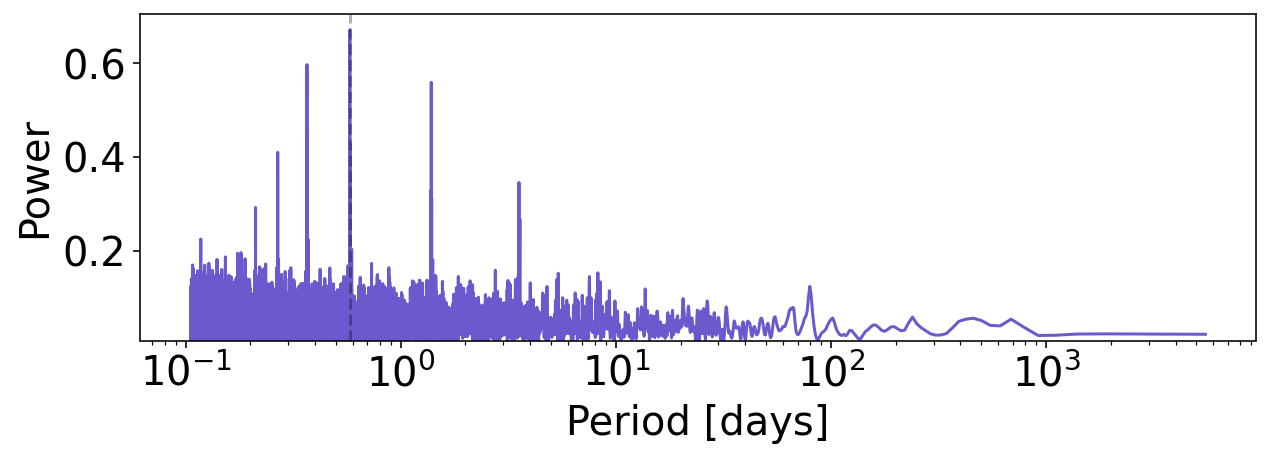

In [162]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,3))
ax.plot(p, dS, color='slateblue')
ax.set_xscale('log')
ax.axvline(p[np.argmax(dS)], color='k', ls='--', alpha=0.3)
ax.set_ylim(0.01)
ax.set_xlabel("Period [days]")
ax.set_ylabel("Power")

print (f"Period with highest power: {p[np.argmax(dS)].round(4)} days")


Nice! We can see that this approach was able to also recover the true period of the injected RR Lyrae nearly four times faster than the two-fold approach.

### Method 3
Here we explore the scenario if the user wants to use a customized period grid (i.e linear grid -- never a good idea, just using this for the demo). This can be done via the `_score` method. Generally, this approach can save lots of computation time if you know or have optimized a period grid to the specific cadence of your survey window

Period with highest power: 0.5802 days


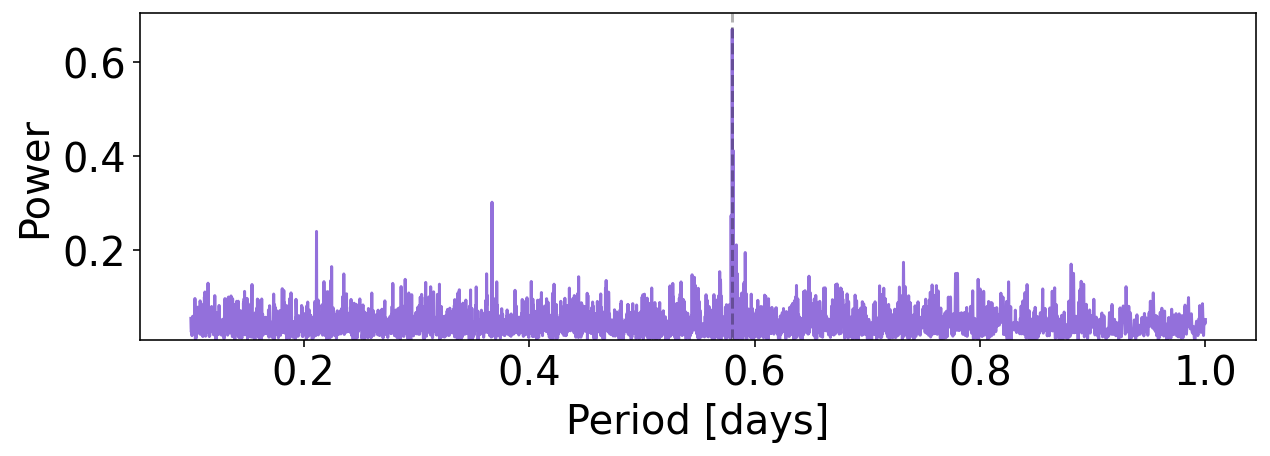

In [158]:
# Build a custom linear grid
custom_grid = np.concatenate([np.linspace(0.1, 0.5, 2_000), 
                                        np.linspace(0.5, 1, 5_000)])

# Build model
model = periodic.LombScargleMultiband(fit_period=False,
                                      optimizer_kwds={"quiet": False},
                                      Nterms_base=1,
                                      Nterms_band=1,
                                      center_data=True).fit(phot['mjd'], phot['flux'], phot['flux_err'],
                                                            filts=phot['band']) 
# Power
dS_ = model.score(custom_grid)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,3))
ax.plot(custom_grid, dS_, color='mediumpurple')
ax.axvline(custom_grid[np.argmax(dS_)], color='k', ls='--', alpha=0.3)
ax.set_ylim(0.01)
ax.set_xlabel("Period [days]")
ax.set_ylabel("Power")

print (f"Period with highest power: {custom_grid[np.argmax(dS_)].round(4)} days")

hoorayyy🎉 we see that our custom period grid can find the correct period we injected!